In [1]:
!pip install xgboost
!pip install joblib


[notice] A new release of pip is available: 23.1.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle
from flask import Flask, jsonify, request
import joblib

In [3]:
# read csv data
df = pd.read_csv('bus-breakdown-and-delays.csv', low_memory=False)
df.head()

,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,How_Long_Delayed,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,Have_You_Alerted_OPT,Informed_On,Incident_Number,Last_Updated_On,Breakdown_or_Running_Late,School_Age_or_PreK
0,2015-2016,1227538,Special Ed AM Run,2621,J711,Heavy Traffic,75003,2015-11-05T08:10:00.000,2015-11-05T08:12:00.000,New Jersey,...,NaN,11,Yes,No,Yes,2015-11-05T08:12:00.000,NaN,2015-11-05T08:12:14.000,Running Late,School-Age
1,2015-2016,1227539,Special Ed AM Run,1260,M351,Heavy Traffic,06716,2015-11-05T08:10:00.000,2015-11-05T08:12:00.000,Manhattan,...,20MNS,2,Yes,Yes,No,2015-11-05T08:12:00.000,NaN,2015-11-05T08:13:34.000,Running Late,School-Age
2,2015-2016,1227540,Pre-K/EI,418,3,Heavy Traffic,C445,2015-11-05T08:09:00.000,2015-11-05T08:13:00.000,Bronx,...,15MIN,8,Yes,Yes,Yes,2015-11-05T08:13:00.000,NaN,2015-11-05T08:13:22.000,Running Late,Pre-K
3,2015-2016,1227541,Special Ed AM Run,4522,M271,Heavy Traffic,02699,2015-11-05T08:12:00.000,2015-11-05T08:14:00.000,Manhattan,...,15 MIN,6,No,No,No,2015-11-05T08:14:00.000,NaN,2015-11-05T08:14:04.000,Running Late,School-Age
4,2015-2016,1227542,Special Ed AM Run,3124,M373,Heavy Traffic,02116,2015-11-05T08:13:00.000,2015-11-05T08:14:00.000,Manhattan,...,NaN,6,No,No,No,2015-11-05T08:14:00.000,NaN,2015-11-05T08:14:08.000,Running Late,School-Age


In [4]:
df.describe()

,Busbreakdown_ID,Number_Of_Students_On_The_Bus
count,3.794120e+05,379412.000000
mean,1.410723e+06,3.494162
std,1.154315e+05,74.213592
min,1.212691e+06,0.000000
25%,1.311426e+06,0.000000
50%,1.407630e+06,0.000000
75%,1.512374e+06,3.000000
max,1.605584e+06,9658.000000


In [5]:
df.shape

(379412, 21)

In [6]:
df['Number_Of_Students_On_The_Bus'].value_counts()

0       233779
2        21658
1        21388
3        20293
4        16810
         ...  
1420         1
1449         1
2557         1
4570         1
3258         1
Name: Number_Of_Students_On_The_Bus, Length: 255, dtype: int64

In [7]:
df.dtypes

School_Year                        object
Busbreakdown_ID                     int64
Run_Type                           object
Bus_No                             object
Route_Number                       object
Reason                             object
Schools_Serviced                   object
Occurred_On                        object
Created_On                         object
Boro                               object
Bus_Company_Name                   object
How_Long_Delayed                   object
Number_Of_Students_On_The_Bus       int64
Has_Contractor_Notified_Schools    object
Has_Contractor_Notified_Parents    object
Have_You_Alerted_OPT               object
Informed_On                        object
Incident_Number                    object
Last_Updated_On                    object
Breakdown_or_Running_Late          object
School_Age_or_PreK                 object
dtype: object

Text(0.5, 1.0, 'Distribution of Missing Data by Variable ')

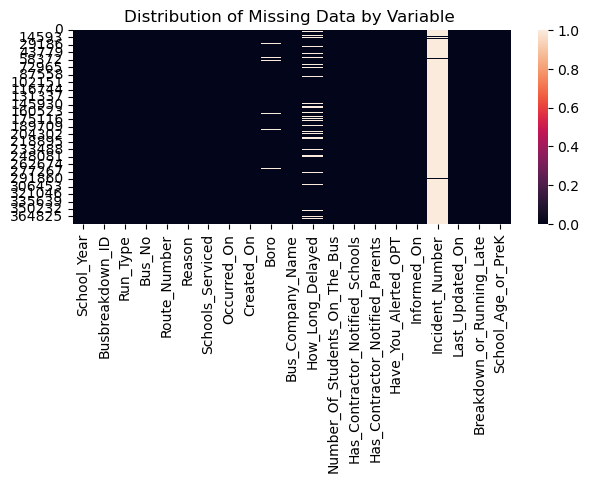

In [8]:
sns.heatmap(df.isnull()) #See distribution of missing data 
plt.figsize = (5,2.5)
plt.tight_layout()
plt.title('Distribution of Missing Data by Variable ')

In [9]:
# Display details of dataset 
print ("Rows :" ,df.shape[0]) 
print ("Columns :" ,df.shape[1]) 
print ("\nFeatures :\n" ,df.columns.tolist()) 
print ("\nMissing values : \n", df.isnull().sum()) 
print ("\nUnique values : \n",df.nunique())

Rows : 379412
Columns : 21

Features :
 ['School_Year', 'Busbreakdown_ID', 'Run_Type', 'Bus_No', 'Route_Number', 'Reason', 'Schools_Serviced', 'Occurred_On', 'Created_On', 'Boro', 'Bus_Company_Name', 'How_Long_Delayed', 'Number_Of_Students_On_The_Bus', 'Has_Contractor_Notified_Schools', 'Has_Contractor_Notified_Parents', 'Have_You_Alerted_OPT', 'Informed_On', 'Incident_Number', 'Last_Updated_On', 'Breakdown_or_Running_Late', 'School_Age_or_PreK']

Missing values : 
 School_Year                             0
Busbreakdown_ID                         0
Run_Type                                3
Bus_No                                 10
Route_Number                            7
Reason                                  2
Schools_Serviced                        7
Occurred_On                             0
Created_On                              0
Boro                                11095
Bus_Company_Name                        0
How_Long_Delayed                    43138
Number_Of_Students_On_The

# EDA

## What is the breakdown or running late incidents in the top 5 boroughs?

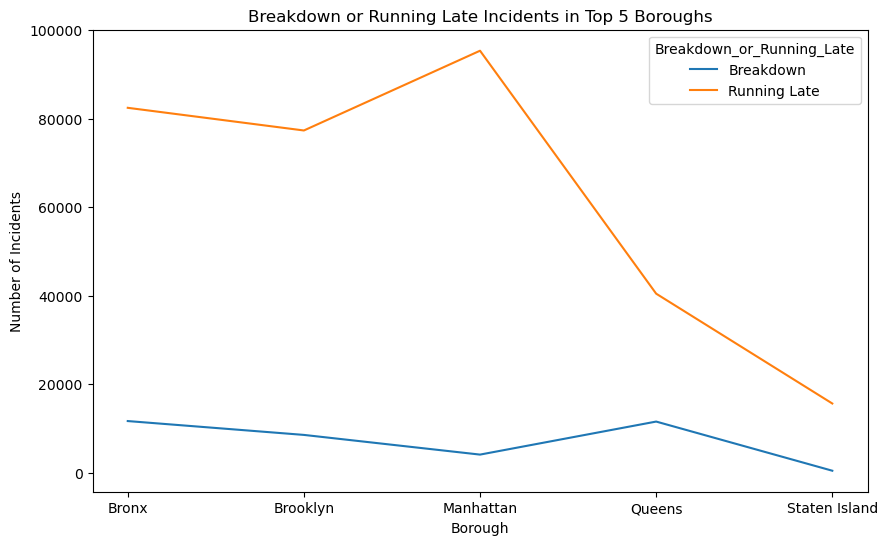

In [10]:
# group by boro and breakdown_or_running_late
grouped = df.groupby(['Boro', 'Breakdown_or_Running_Late']).size().reset_index(name='count')

# filter for breakdown or running late incidents
subset = grouped[grouped['Breakdown_or_Running_Late'].isin(['Breakdown', 'Running Late'])]

# get the top 5 boroughs with the most incidents
top_boroughs = subset.groupby('Boro')['count'].sum().nlargest(5).index.tolist()

# filter for only the top 5 boroughs
subset_top = subset[subset['Boro'].isin(top_boroughs)]

# create line plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='Boro', y='count', hue='Breakdown_or_Running_Late', data=subset_top, ax=ax)

# set plot title and axis labels
ax.set_title('Breakdown or Running Late Incidents in Top 5 Boroughs')
ax.set_xlabel('Borough')
ax.set_ylabel('Number of Incidents')

# show plot
plt.show()

In [11]:
# group by boro and breakdown_or_running_late
grouped = df.groupby(['Boro', 'Breakdown_or_Running_Late']).size().reset_index(name='count')

# filter for breakdown or running late incidents
subset = grouped[grouped['Breakdown_or_Running_Late'].isin(['Breakdown', 'Running Late'])]

# get the top 5 boroughs with the most incidents
top_boroughs = subset.groupby('Boro')['count'].sum().nlargest(5).index.tolist()

# filter for only the top 5 boroughs
subset_top = subset[subset['Boro'].isin(top_boroughs)]

# create pivot table
pivot_table = pd.pivot_table(subset_top, values='count', index='Boro', columns='Breakdown_or_Running_Late', aggfunc=np.sum)

# set column names
pivot_table.columns.name = None

# show pivot table
print(pivot_table)

               Breakdown  Running Late
Boro                                  
Bronx              11710         82446
Brooklyn            8582         77327
Manhattan           4136         95337
Queens             11595         40477
Staten Island        495         15674


# What is the bus breakdown reasons by month?

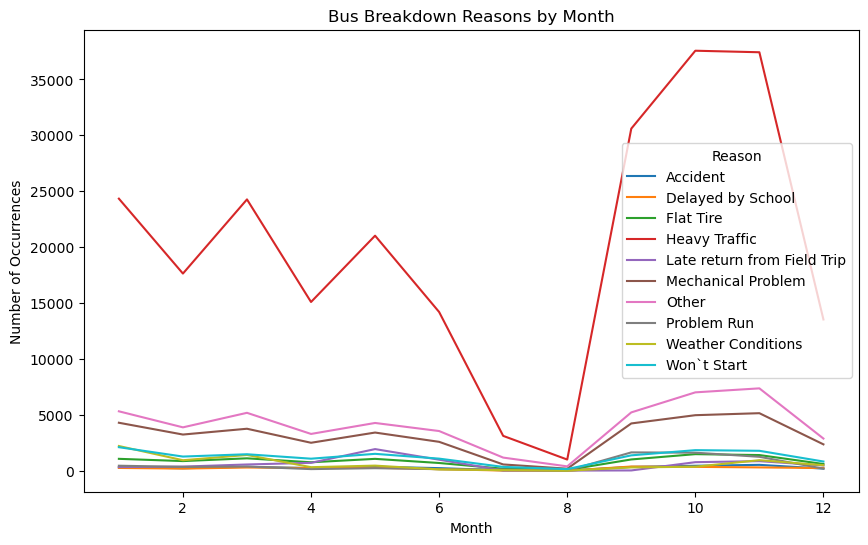

In [12]:
# Convert the Occurred_On column to datetime
df['Occurred_On'] = pd.to_datetime(df['Occurred_On'])

# Extract the month from the Occurred_On column
df['Month'] = df['Occurred_On'].dt.month

# Group the data by month and reason and count the number of occurrences
grouped = df.groupby(['Month', 'Reason']).size().unstack(fill_value=0)

# Plot the data as a line graph
ax = grouped.plot(kind='line', figsize=(10, 6))

# Set the title and axis labels
ax.set_title('Bus Breakdown Reasons by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Occurrences')

# Show the plot
plt.show()

# Top 5 reason every month bus breakdown

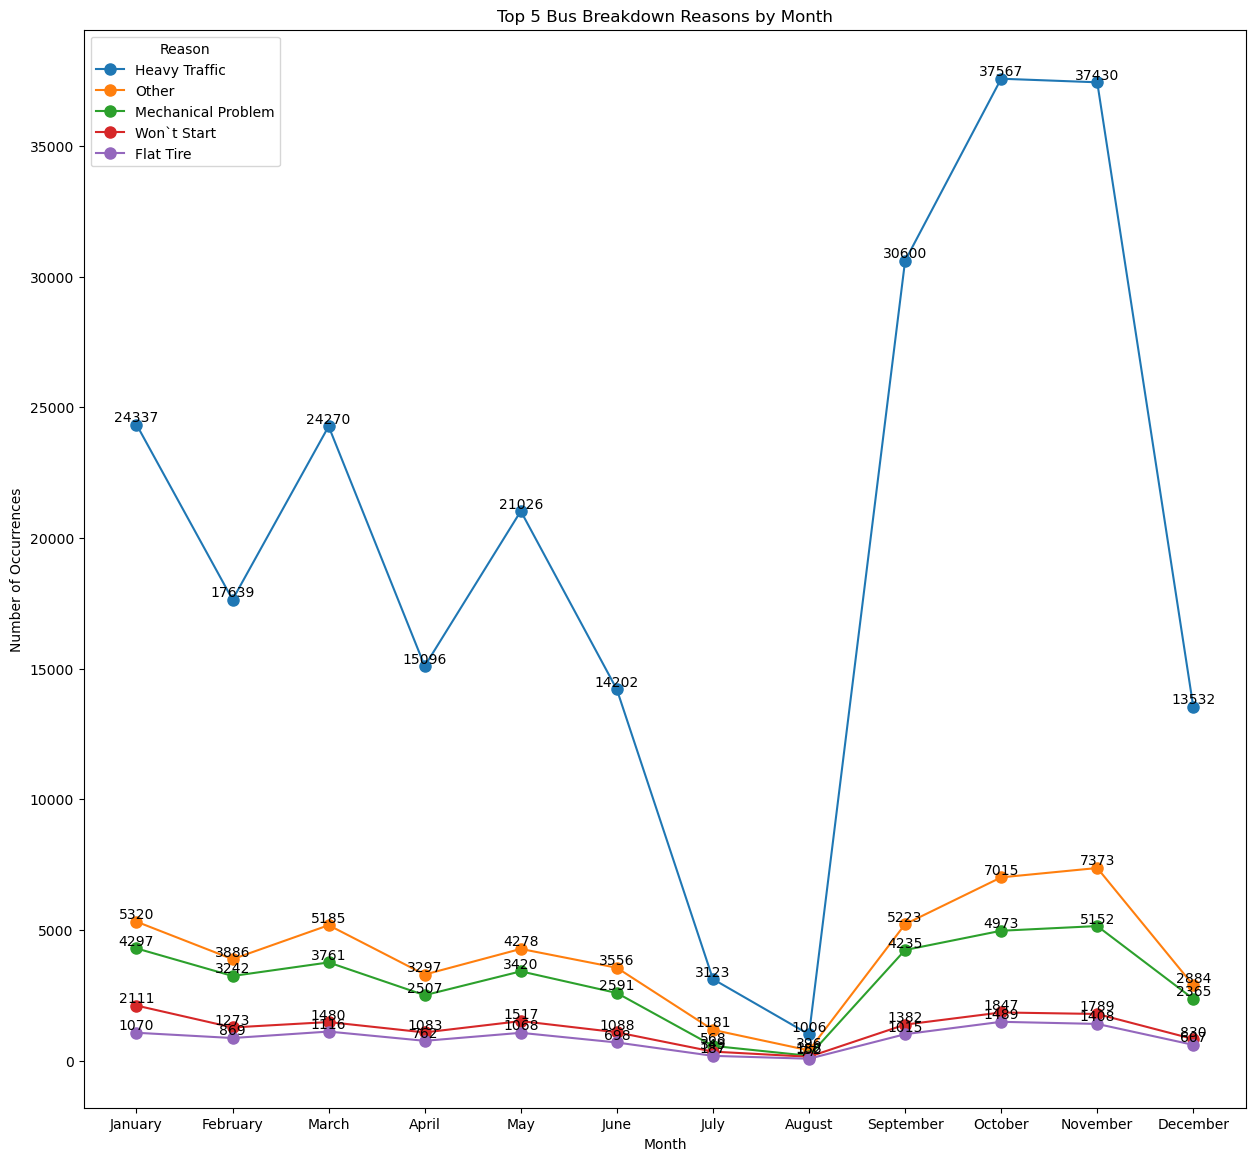

In [13]:
# Convert the Occurred_On column to datetime
df['Occurred_On'] = pd.to_datetime(df['Occurred_On'])

# Extract the month from the Occurred_On column
df['Month'] = df['Occurred_On'].dt.month

# Group the data by month and reason and count the number of occurrences
grouped = df.groupby(['Month', 'Reason']).size().unstack(fill_value=0)

# Sort the values by the sum of occurrences for each reason
sums = grouped.sum(axis=0)
sums_sorted = sums.sort_values(ascending=False)

# Select the top 5 reasons
top_5_reasons = sums_sorted.index[:5]

# Filter the data to include only the top 5 reasons
grouped_top_5 = grouped[top_5_reasons]

# Define the month names
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

# Plot the data as a line graph
ax = grouped_top_5.plot(kind='line', figsize=(15, 14), marker='o', markersize=8)

# Set the title and axis labels
ax.set_title('Top 5 Bus Breakdown Reasons by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Occurrences')

# Set the x-axis labels
ax.set_xticks(range(1, 13))
ax.set_xticklabels(months)

# Add data point labels
for i in range(grouped_top_5.shape[1]):
    for j in range(grouped_top_5.shape[0]):
        val = grouped_top_5.iloc[j, i]
        ax.text(j+1, val+5, str(val), ha='center', va='bottom')

# Show the plot
plt.show()

# Data Cleaning

In [14]:
#Drop incident number, most of column is missing
df = df.drop(['Incident_Number'], axis = 1) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379412 entries, 0 to 379411
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   School_Year                      379412 non-null  object        
 1   Busbreakdown_ID                  379412 non-null  int64         
 2   Run_Type                         379409 non-null  object        
 3   Bus_No                           379402 non-null  object        
 4   Route_Number                     379405 non-null  object        
 5   Reason                           379410 non-null  object        
 6   Schools_Serviced                 379405 non-null  object        
 7   Occurred_On                      379412 non-null  datetime64[ns]
 8   Created_On                       379412 non-null  object        
 9   Boro                             368317 non-null  object        
 10  Bus_Company_Name                 379412 non-

In [15]:
print(df.columns)

Index(['School_Year', 'Busbreakdown_ID', 'Run_Type', 'Bus_No', 'Route_Number',
       'Reason', 'Schools_Serviced', 'Occurred_On', 'Created_On', 'Boro',
       'Bus_Company_Name', 'How_Long_Delayed', 'Number_Of_Students_On_The_Bus',
       'Has_Contractor_Notified_Schools', 'Has_Contractor_Notified_Parents',
       'Have_You_Alerted_OPT', 'Informed_On', 'Last_Updated_On',
       'Breakdown_or_Running_Late', 'School_Age_or_PreK', 'Month'],
      dtype='object')


In [16]:
#Extract digits from string column 
df.loc[:, 'Delay'] = df['How_Long_Delayed'].str.extract('(\d+)').copy()
#Check if regex worked- Yes!
df.head() 

,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,Have_You_Alerted_OPT,Informed_On,Last_Updated_On,Breakdown_or_Running_Late,School_Age_or_PreK,Month,Delay
0,2015-2016,1227538,Special Ed AM Run,2621,J711,Heavy Traffic,75003,2015-11-05 08:10:00,2015-11-05T08:12:00.000,New Jersey,...,11,Yes,No,Yes,2015-11-05T08:12:00.000,2015-11-05T08:12:14.000,Running Late,School-Age,11,NaN
1,2015-2016,1227539,Special Ed AM Run,1260,M351,Heavy Traffic,06716,2015-11-05 08:10:00,2015-11-05T08:12:00.000,Manhattan,...,2,Yes,Yes,No,2015-11-05T08:12:00.000,2015-11-05T08:13:34.000,Running Late,School-Age,11,20
2,2015-2016,1227540,Pre-K/EI,418,3,Heavy Traffic,C445,2015-11-05 08:09:00,2015-11-05T08:13:00.000,Bronx,...,8,Yes,Yes,Yes,2015-11-05T08:13:00.000,2015-11-05T08:13:22.000,Running Late,Pre-K,11,15
3,2015-2016,1227541,Special Ed AM Run,4522,M271,Heavy Traffic,02699,2015-11-05 08:12:00,2015-11-05T08:14:00.000,Manhattan,...,6,No,No,No,2015-11-05T08:14:00.000,2015-11-05T08:14:04.000,Running Late,School-Age,11,15
4,2015-2016,1227542,Special Ed AM Run,3124,M373,Heavy Traffic,02116,2015-11-05 08:13:00,2015-11-05T08:14:00.000,Manhattan,...,6,No,No,No,2015-11-05T08:14:00.000,2015-11-05T08:14:08.000,Running Late,School-Age,11,NaN


In [17]:
df[df['Delay'].isnull()]#Check if data is null
#We see that there's question marks or other irregularaties- lets drop this data 

,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,Have_You_Alerted_OPT,Informed_On,Last_Updated_On,Breakdown_or_Running_Late,School_Age_or_PreK,Month,Delay
0,2015-2016,1227538,Special Ed AM Run,2621,J711,Heavy Traffic,75003,2015-11-05 08:10:00,2015-11-05T08:12:00.000,New Jersey,...,11,Yes,No,Yes,2015-11-05T08:12:00.000,2015-11-05T08:12:14.000,Running Late,School-Age,11,NaN
4,2015-2016,1227542,Special Ed AM Run,3124,M373,Heavy Traffic,02116,2015-11-05 08:13:00,2015-11-05T08:14:00.000,Manhattan,...,6,No,No,No,2015-11-05T08:14:00.000,2015-11-05T08:14:08.000,Running Late,School-Age,11,NaN
16,2015-2016,1227558,Special Ed AM Run,2052,L524,Flat Tire,17246,2015-11-05 08:22:00,2015-11-05T08:25:00.000,NaN,...,4,Yes,Yes,Yes,2015-11-05T08:25:00.000,2015-11-05T08:25:11.000,Running Late,School-Age,11,NaN
18,2015-2016,1227561,Special Ed AM Run,2508,L531,Heavy Traffic,13009,2015-11-05 08:25:00,2015-11-05T08:26:00.000,Bronx,...,4,No,No,No,2015-11-05T08:26:00.000,2015-11-05T08:26:54.000,Running Late,School-Age,11,NaN
22,2015-2016,1227077,General Ed AM Run,2675,X2189,Other,10095,2015-11-04 07:04:00,2015-11-04T07:11:00.000,Bronx,...,0,Yes,Yes,No,2015-11-04T07:11:00.000,2015-11-04T07:11:53.000,Breakdown,School-Age,11,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379383,2018-2019,1565281,Special Ed AM Run,86D,Q794,Mechanical Problem,"24515,24750",2019-06-26 11:25:00,2019-06-26T11:32:00.000,Queens,...,6,Yes,No,No,2019-06-26T11:32:00.000,1900-01-01T00:00:00.000,Breakdown,School-Age,6,NaN
379385,2018-2019,1565283,General Ed PM Run,1040,Q9116,Mechanical Problem,30300,2019-06-26 11:32:00,2019-06-26T11:37:00.000,Queens,...,0,No,No,No,2019-06-26T11:37:00.000,1900-01-01T00:00:00.000,Breakdown,School-Age,6,NaN
379386,2018-2019,1565284,General Ed AM Run,2333,K1539,Mechanical Problem,"15032,15038,15528,15821",2019-06-26 11:34:00,2019-06-26T11:40:00.000,Brooklyn,...,0,No,No,No,2019-06-26T11:40:00.000,1900-01-01T00:00:00.000,Breakdown,School-Age,6,NaN
379394,2018-2019,1565304,General Ed PM Run,2340,K9502,Won`t Start,"15038,15261",2019-06-26 12:45:00,2019-06-26T13:49:00.000,Brooklyn,...,0,No,No,No,2019-06-26T13:49:00.000,1900-01-01T00:00:00.000,Breakdown,School-Age,6,NaN


In [18]:
df_clean = df.dropna() #Drop remainaing NAs
df_clean.info()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325760 entries, 1 to 379411
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   School_Year                      325760 non-null  object        
 1   Busbreakdown_ID                  325760 non-null  int64         
 2   Run_Type                         325760 non-null  object        
 3   Bus_No                           325760 non-null  object        
 4   Route_Number                     325760 non-null  object        
 5   Reason                           325760 non-null  object        
 6   Schools_Serviced                 325760 non-null  object        
 7   Occurred_On                      325760 non-null  datetime64[ns]
 8   Created_On                       325760 non-null  object        
 9   Boro                             325760 non-null  object        
 10  Bus_Company_Name                 325760 non-

,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,Have_You_Alerted_OPT,Informed_On,Last_Updated_On,Breakdown_or_Running_Late,School_Age_or_PreK,Month,Delay
1,2015-2016,1227539,Special Ed AM Run,1260,M351,Heavy Traffic,06716,2015-11-05 08:10:00,2015-11-05T08:12:00.000,Manhattan,...,2,Yes,Yes,No,2015-11-05T08:12:00.000,2015-11-05T08:13:34.000,Running Late,School-Age,11,20
2,2015-2016,1227540,Pre-K/EI,418,3,Heavy Traffic,C445,2015-11-05 08:09:00,2015-11-05T08:13:00.000,Bronx,...,8,Yes,Yes,Yes,2015-11-05T08:13:00.000,2015-11-05T08:13:22.000,Running Late,Pre-K,11,15
3,2015-2016,1227541,Special Ed AM Run,4522,M271,Heavy Traffic,02699,2015-11-05 08:12:00,2015-11-05T08:14:00.000,Manhattan,...,6,No,No,No,2015-11-05T08:14:00.000,2015-11-05T08:14:04.000,Running Late,School-Age,11,15
5,2015-2016,1227543,Special Ed AM Run,HT1502,W796,Heavy Traffic,75407,2015-11-05 07:58:00,2015-11-05T08:14:00.000,Westchester,...,1,Yes,Yes,Yes,2015-11-05T08:14:00.000,2015-11-05T08:14:15.000,Running Late,School-Age,11,30
6,2015-2016,1227544,Special Ed AM Run,142,W633,Heavy Traffic,75670,2015-11-05 08:24:00,2015-11-05T08:15:00.000,Westchester,...,3,Yes,No,No,2015-11-05T08:15:00.000,2015-11-05T08:16:53.000,Running Late,School-Age,11,20


In [19]:
df_clean = df_clean.dropna() #Drop new NAs 
df_clean.isnull().sum() #Check that no NAs are left 

School_Year                        0
Busbreakdown_ID                    0
Run_Type                           0
Bus_No                             0
Route_Number                       0
Reason                             0
Schools_Serviced                   0
Occurred_On                        0
Created_On                         0
Boro                               0
Bus_Company_Name                   0
How_Long_Delayed                   0
Number_Of_Students_On_The_Bus      0
Has_Contractor_Notified_Schools    0
Has_Contractor_Notified_Parents    0
Have_You_Alerted_OPT               0
Informed_On                        0
Last_Updated_On                    0
Breakdown_or_Running_Late          0
School_Age_or_PreK                 0
Month                              0
Delay                              0
dtype: int64

In [20]:
#Convert string to integer 
df_clean.loc[:, 'Delay'] = pd.to_numeric(df_clean['Delay'])

In [21]:
#Drop original column 
df_clean = df_clean.drop(['How_Long_Delayed'], axis = 1)

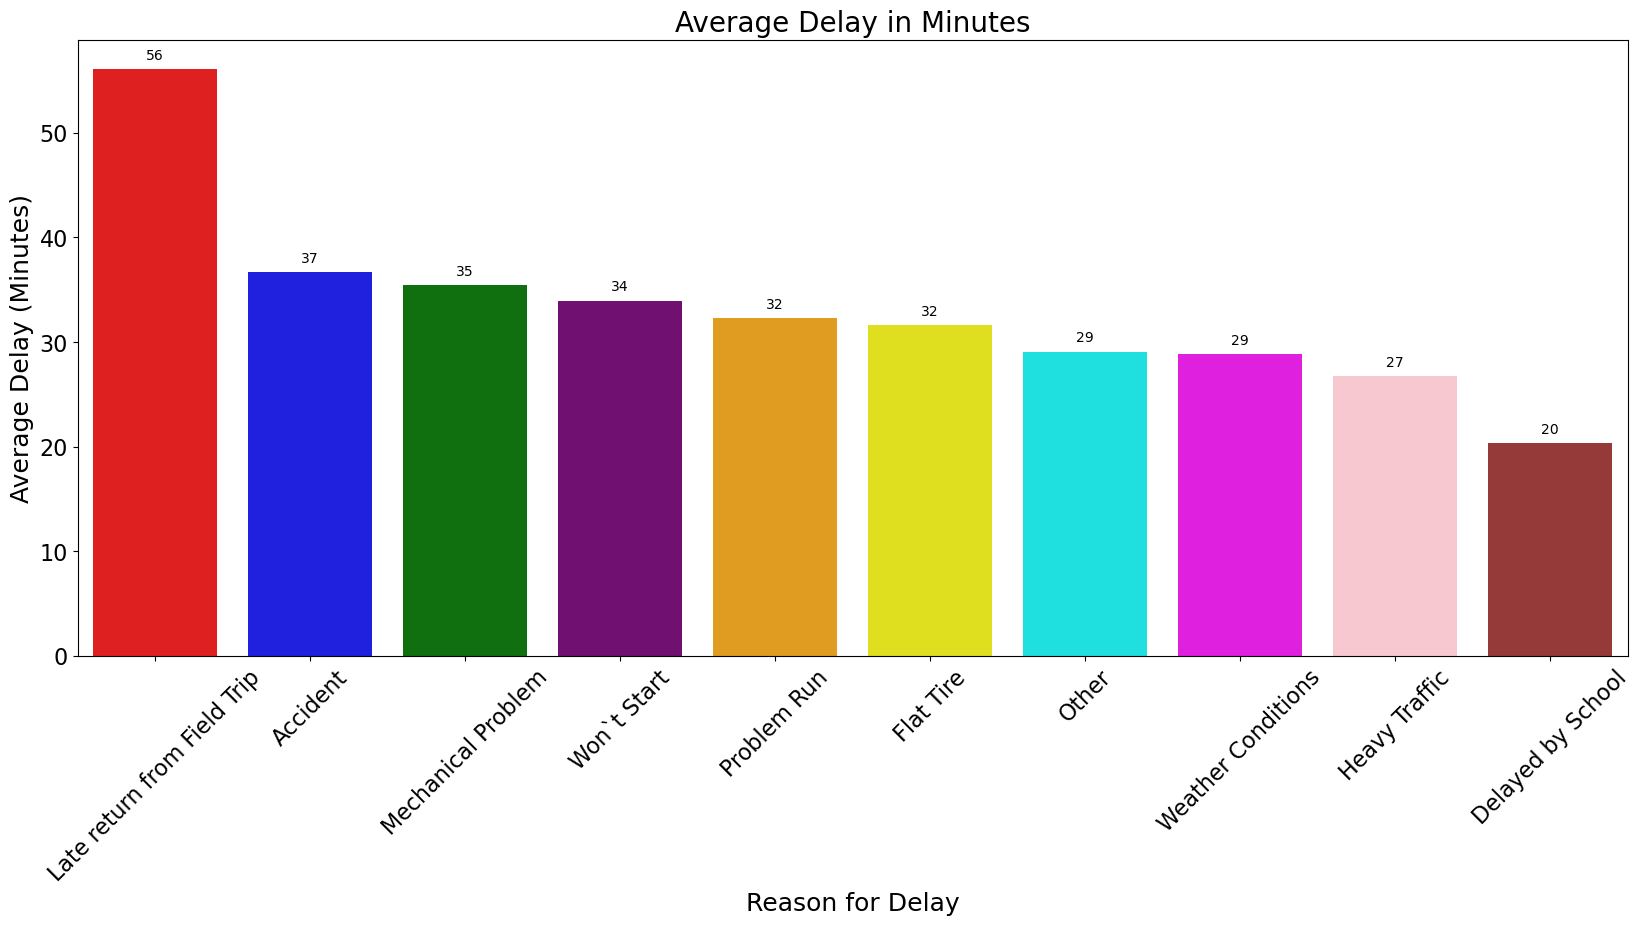

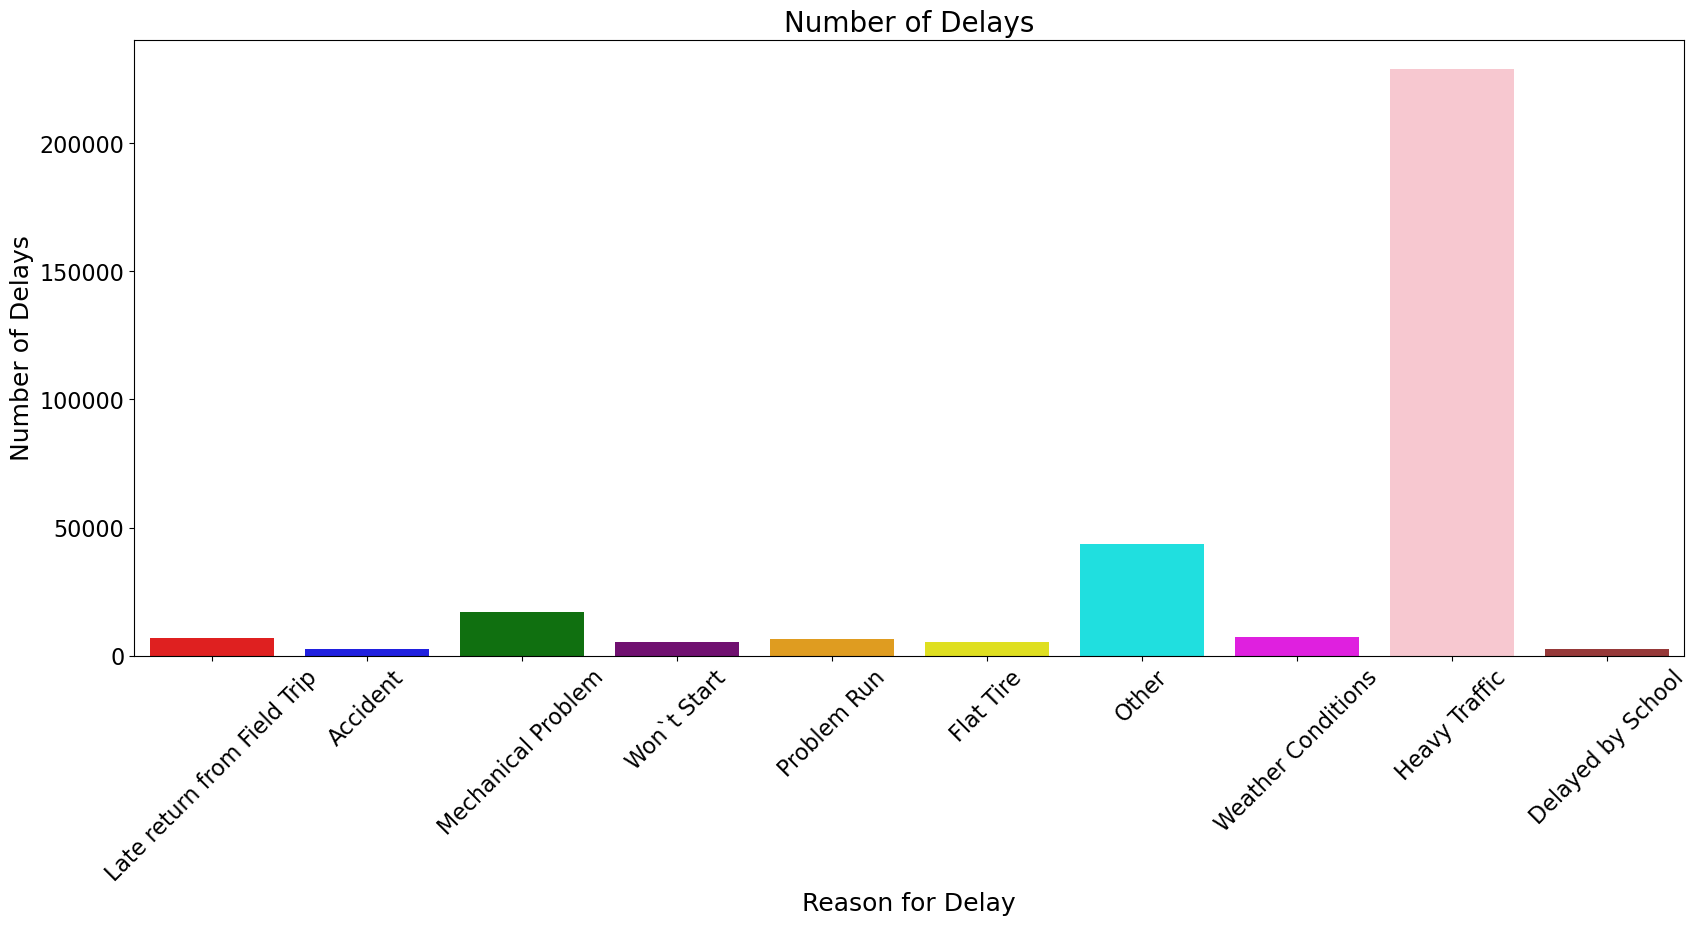

In [22]:
import seaborn as sns

# Define a list of 10 different colors
colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'cyan', 'magenta', 'pink', 'brown']

# Create a pivot table of reasons and delay
reasons = pd.pivot_table(df_clean, index='Reason', values='Delay', aggfunc=[np.mean, np.max, np.size]).sort_values(by=('mean', 'Delay'), ascending=False)

# Create countplot
plt.figure(figsize=(20, 8))
ax = sns.barplot(x=reasons.index, y=reasons[('mean', 'Delay')], palette=colors)

# Plot the average delay chart
#sns.barplot(x=reasons.index, y=reasons[('mean', 'Delay')], palette=colors)
plt.title('Average Delay in Minutes', fontsize=20)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Reason for Delay', fontsize=18)
plt.ylabel('Average Delay (Minutes)', fontsize=18)
  # Add labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.show()



# Plot the number of delays chart
plt.figure(figsize=(20, 8))
sns.barplot(x=reasons.index, y=reasons[('size', 'Delay')], palette=colors)
plt.title('Number of Delays', fontsize=20)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Reason for Delay', fontsize=18)
plt.ylabel('Number of Delays', fontsize=18)
plt.show()

Text(0.5, 0, 'Delay Time (minutes)')

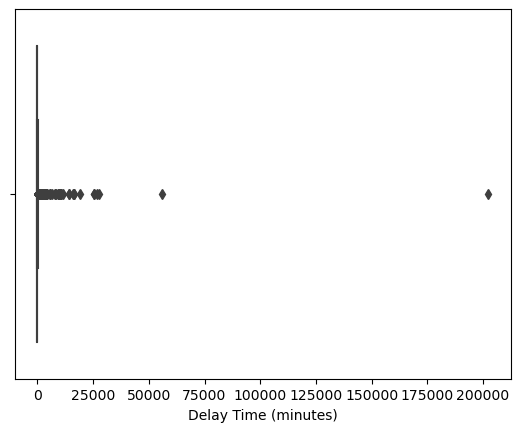

In [23]:
#Looks like two clear outliers- 1 around 50,000 and the other around 200,000 Let's remove 
sns.boxplot( x = df_clean['Delay'])
plt.xlabel('Delay Time (minutes)')


<AxesSubplot:xlabel='Delay'>

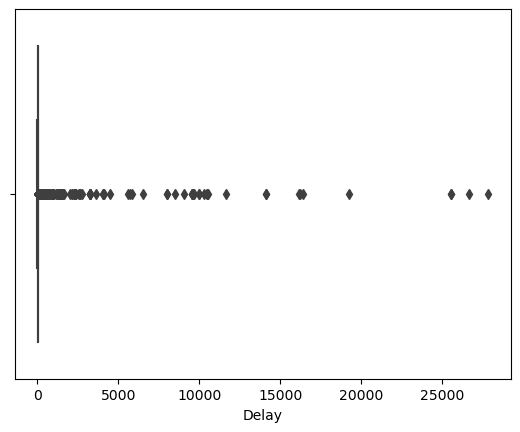

In [24]:
df_exoutliers = df_clean[df_clean['Delay'] < 50000]
sns.boxplot(x = df_exoutliers['Delay']) #Check if we need to remove further outliers 

In [25]:
df_clean.head()

,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,Have_You_Alerted_OPT,Informed_On,Last_Updated_On,Breakdown_or_Running_Late,School_Age_or_PreK,Month,Delay
1,2015-2016,1227539,Special Ed AM Run,1260,M351,Heavy Traffic,06716,2015-11-05 08:10:00,2015-11-05T08:12:00.000,Manhattan,...,2,Yes,Yes,No,2015-11-05T08:12:00.000,2015-11-05T08:13:34.000,Running Late,School-Age,11,20
2,2015-2016,1227540,Pre-K/EI,418,3,Heavy Traffic,C445,2015-11-05 08:09:00,2015-11-05T08:13:00.000,Bronx,...,8,Yes,Yes,Yes,2015-11-05T08:13:00.000,2015-11-05T08:13:22.000,Running Late,Pre-K,11,15
3,2015-2016,1227541,Special Ed AM Run,4522,M271,Heavy Traffic,02699,2015-11-05 08:12:00,2015-11-05T08:14:00.000,Manhattan,...,6,No,No,No,2015-11-05T08:14:00.000,2015-11-05T08:14:04.000,Running Late,School-Age,11,15
5,2015-2016,1227543,Special Ed AM Run,HT1502,W796,Heavy Traffic,75407,2015-11-05 07:58:00,2015-11-05T08:14:00.000,Westchester,...,1,Yes,Yes,Yes,2015-11-05T08:14:00.000,2015-11-05T08:14:15.000,Running Late,School-Age,11,30
6,2015-2016,1227544,Special Ed AM Run,142,W633,Heavy Traffic,75670,2015-11-05 08:24:00,2015-11-05T08:15:00.000,Westchester,...,3,Yes,No,No,2015-11-05T08:15:00.000,2015-11-05T08:16:53.000,Running Late,School-Age,11,20


In [26]:
df_clean['Route_Number'].value_counts()


1        4225
2        3105
5        2623
3        2617
4        1519
         ... 
K662        1
K9172       1
K9485       1
K9131       1
M9138       1
Name: Route_Number, Length: 13862, dtype: int64

In [27]:
pd.pivot_table(df_clean, index = 'Route_Number', 
               values = 'Delay', 
               aggfunc = [np.mean,np.size]).sort_values(by = ('size','Delay'), 
                                                         ascending = False).head(6)

,mean,size
,Delay,Delay
Route_Number,,
1,21.269349,4225
2,22.322383,3105
5,20.535646,2623
3,21.853267,2617
4,20.259381,1519
6,22.498741,1191


In [28]:
#Filter to see cases where route is top 6 in # of delays
routes = ['1','2','3','5','4','6']
top_routes = df_clean[df_clean['Route_Number'].isin(routes)] 

In [29]:
routes_pivot = pd.pivot_table(top_routes, 
                              index = 'Route_Number', 
                              values = 'Delay', 
                              aggfunc = [np.mean,np.size])
routes_pivot.head(6)

,mean,size
,Delay,Delay
Route_Number,,
1,21.269349,4225
2,22.322383,3105
3,21.853267,2617
4,20.259381,1519
5,20.535646,2623
6,22.498741,1191


In [30]:
df_clean.head()

,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,Have_You_Alerted_OPT,Informed_On,Last_Updated_On,Breakdown_or_Running_Late,School_Age_or_PreK,Month,Delay
1,2015-2016,1227539,Special Ed AM Run,1260,M351,Heavy Traffic,06716,2015-11-05 08:10:00,2015-11-05T08:12:00.000,Manhattan,...,2,Yes,Yes,No,2015-11-05T08:12:00.000,2015-11-05T08:13:34.000,Running Late,School-Age,11,20
2,2015-2016,1227540,Pre-K/EI,418,3,Heavy Traffic,C445,2015-11-05 08:09:00,2015-11-05T08:13:00.000,Bronx,...,8,Yes,Yes,Yes,2015-11-05T08:13:00.000,2015-11-05T08:13:22.000,Running Late,Pre-K,11,15
3,2015-2016,1227541,Special Ed AM Run,4522,M271,Heavy Traffic,02699,2015-11-05 08:12:00,2015-11-05T08:14:00.000,Manhattan,...,6,No,No,No,2015-11-05T08:14:00.000,2015-11-05T08:14:04.000,Running Late,School-Age,11,15
5,2015-2016,1227543,Special Ed AM Run,HT1502,W796,Heavy Traffic,75407,2015-11-05 07:58:00,2015-11-05T08:14:00.000,Westchester,...,1,Yes,Yes,Yes,2015-11-05T08:14:00.000,2015-11-05T08:14:15.000,Running Late,School-Age,11,30
6,2015-2016,1227544,Special Ed AM Run,142,W633,Heavy Traffic,75670,2015-11-05 08:24:00,2015-11-05T08:15:00.000,Westchester,...,3,Yes,No,No,2015-11-05T08:15:00.000,2015-11-05T08:16:53.000,Running Late,School-Age,11,20


In [31]:
df_clean['Bus_Company_Name'].value_counts()

LEESEL TRANSPORTATION CORP (B2192)     42339
G.V.C., LTD.                           21442
PIONEER TRANSPORTATION CORP            17723
RELIANT TRANSPORTATION, INC (B2321)    15333
BORO TRANSIT, INC.                     14336
                                       ...  
R & C TRANSIT, INC. (B232                  2
1967                                       1
phillip bus service                        1
FORTUNA BUS COMPANY                        1
Ms.                                        1
Name: Bus_Company_Name, Length: 118, dtype: int64

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '2018-2019'),
  Text(1, 0, '2017-2018'),
  Text(2, 0, '2016-2017'),
  Text(3, 0, '2015-2016'),
  Text(4, 0, '2019-2020')])

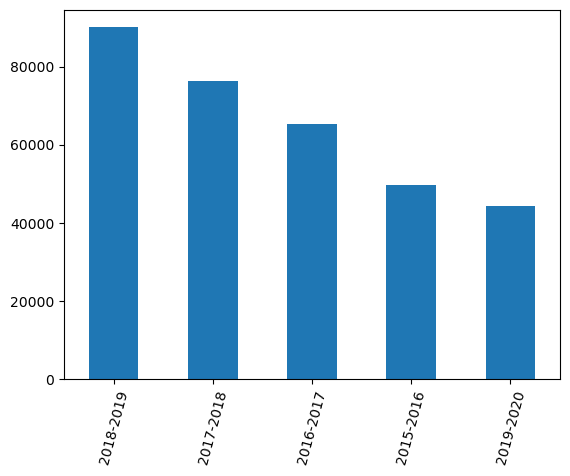

In [32]:
#First Let's remove unnecessary features, checking 1 by 1 

#School Year- is it relevant? 
df_clean['School_Year'].value_counts().plot(kind = 'bar')
plt.xticks(rotation = 75) #Make Data cleaner to read 

#See an increasing trend year on year in quantity-let's investigate if there's any significant deviations in delay by year

In [33]:
#Let's first see average delay, across the dataset 
df_clean['Delay'].mean() #Around 29 mins is the average delay time 

28.52876043713163

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '2015-2016'),
  Text(1, 0, '2016-2017'),
  Text(2, 0, '2017-2018'),
  Text(3, 0, '2018-2019'),
  Text(4, 0, '2019-2020')])

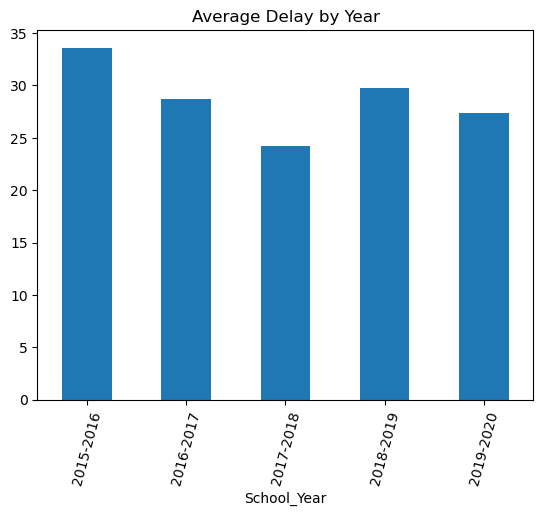

In [34]:
pd.pivot_table(df_clean, index = 'School_Year', values = 'Delay', aggfunc = np.mean).plot(kind = 'bar')
plt.legend().remove() #Get rid of legend 
plt.title('Average Delay by Year')
plt.xticks(rotation = 75) #Make easier to read 

#Doesn't look any year is terribly far off from another but also not congruent- will keep for now 

In [35]:
df_clean.head() #Let's check what the data looked like again 


,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,Have_You_Alerted_OPT,Informed_On,Last_Updated_On,Breakdown_or_Running_Late,School_Age_or_PreK,Month,Delay
1,2015-2016,1227539,Special Ed AM Run,1260,M351,Heavy Traffic,06716,2015-11-05 08:10:00,2015-11-05T08:12:00.000,Manhattan,...,2,Yes,Yes,No,2015-11-05T08:12:00.000,2015-11-05T08:13:34.000,Running Late,School-Age,11,20
2,2015-2016,1227540,Pre-K/EI,418,3,Heavy Traffic,C445,2015-11-05 08:09:00,2015-11-05T08:13:00.000,Bronx,...,8,Yes,Yes,Yes,2015-11-05T08:13:00.000,2015-11-05T08:13:22.000,Running Late,Pre-K,11,15
3,2015-2016,1227541,Special Ed AM Run,4522,M271,Heavy Traffic,02699,2015-11-05 08:12:00,2015-11-05T08:14:00.000,Manhattan,...,6,No,No,No,2015-11-05T08:14:00.000,2015-11-05T08:14:04.000,Running Late,School-Age,11,15
5,2015-2016,1227543,Special Ed AM Run,HT1502,W796,Heavy Traffic,75407,2015-11-05 07:58:00,2015-11-05T08:14:00.000,Westchester,...,1,Yes,Yes,Yes,2015-11-05T08:14:00.000,2015-11-05T08:14:15.000,Running Late,School-Age,11,30
6,2015-2016,1227544,Special Ed AM Run,142,W633,Heavy Traffic,75670,2015-11-05 08:24:00,2015-11-05T08:15:00.000,Westchester,...,3,Yes,No,No,2015-11-05T08:15:00.000,2015-11-05T08:16:53.000,Running Late,School-Age,11,20


In [36]:
#Data seems like no noise, we'll drop 
df_clean['Busbreakdown_ID'].value_counts() 

1602184    2
1603512    2
1580876    2
1580874    2
1580873    2
          ..
1371134    1
1371135    1
1371140    1
1371141    1
1565321    1
Name: Busbreakdown_ID, Length: 278328, dtype: int64

In [37]:
df_clean = df_clean.drop(['Busbreakdown_ID'], axis = 1)
df_clean.head()

,School_Year,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,Bus_Company_Name,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,Have_You_Alerted_OPT,Informed_On,Last_Updated_On,Breakdown_or_Running_Late,School_Age_or_PreK,Month,Delay
1,2015-2016,Special Ed AM Run,1260,M351,Heavy Traffic,06716,2015-11-05 08:10:00,2015-11-05T08:12:00.000,Manhattan,HOYT TRANSPORTATION CORP.,2,Yes,Yes,No,2015-11-05T08:12:00.000,2015-11-05T08:13:34.000,Running Late,School-Age,11,20
2,2015-2016,Pre-K/EI,418,3,Heavy Traffic,C445,2015-11-05 08:09:00,2015-11-05T08:13:00.000,Bronx,"G.V.C., LTD.",8,Yes,Yes,Yes,2015-11-05T08:13:00.000,2015-11-05T08:13:22.000,Running Late,Pre-K,11,15
3,2015-2016,Special Ed AM Run,4522,M271,Heavy Traffic,02699,2015-11-05 08:12:00,2015-11-05T08:14:00.000,Manhattan,"RELIANT TRANS, INC. (B232",6,No,No,No,2015-11-05T08:14:00.000,2015-11-05T08:14:04.000,Running Late,School-Age,11,15
5,2015-2016,Special Ed AM Run,HT1502,W796,Heavy Traffic,75407,2015-11-05 07:58:00,2015-11-05T08:14:00.000,Westchester,CHILDREN`S TRANS INC. (B2,1,Yes,Yes,Yes,2015-11-05T08:14:00.000,2015-11-05T08:14:15.000,Running Late,School-Age,11,30
6,2015-2016,Special Ed AM Run,142,W633,Heavy Traffic,75670,2015-11-05 08:24:00,2015-11-05T08:15:00.000,Westchester,MAR-CAN TRANSPORT CO. INC,3,Yes,No,No,2015-11-05T08:15:00.000,2015-11-05T08:16:53.000,Running Late,School-Age,11,20


In [38]:

bus_num = pd.pivot_table(df_clean, index = 'Bus_No', values = 'Delay',aggfunc = np.size).sort_values(by = 'Delay', 
                                                                                                    ascending = False)
bus_num.rename(columns={
    'Delay': 'Delay (counts)'})




#Create pivot to see number of delays by bus number
#We see that a lot have only have 1. 
#Instead of one hot encoding, let's just convert to digits 

,Delay (counts)
Bus_No,
1801,835
1318,770
1107,752
9302,732
1470,716
...,...
58127,1
58166D,1
58176,1


In [39]:
#Extract digits from string column 
df_clean['Bus_Number'] = df_clean['Bus_No'].str.extract('(\d+)') 
#Convert string to integer 
df_clean['Bus_Number'] =  pd.to_numeric(df_clean['Bus_Number']) 
df_clean.isnull().sum() 
#We now have some more NAs- let's do a quick investigation 

School_Year                          0
Run_Type                             0
Bus_No                               0
Route_Number                         0
Reason                               0
Schools_Serviced                     0
Occurred_On                          0
Created_On                           0
Boro                                 0
Bus_Company_Name                     0
Number_Of_Students_On_The_Bus        0
Has_Contractor_Notified_Schools      0
Has_Contractor_Notified_Parents      0
Have_You_Alerted_OPT                 0
Informed_On                          0
Last_Updated_On                      0
Breakdown_or_Running_Late            0
School_Age_or_PreK                   0
Month                                0
Delay                                0
Bus_Number                         175
dtype: int64

In [40]:
#Looks like noisy data, will drop 
df_clean[df_clean['Bus_Number'].isnull()] 
df_clean = df_clean.dropna()
#Drop original column 
df_clean = df_clean.drop(['Bus_No'], axis = 1) 

In [41]:
df_clean.head() 

,School_Year,Run_Type,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,Bus_Company_Name,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,Have_You_Alerted_OPT,Informed_On,Last_Updated_On,Breakdown_or_Running_Late,School_Age_or_PreK,Month,Delay,Bus_Number
1,2015-2016,Special Ed AM Run,M351,Heavy Traffic,06716,2015-11-05 08:10:00,2015-11-05T08:12:00.000,Manhattan,HOYT TRANSPORTATION CORP.,2,Yes,Yes,No,2015-11-05T08:12:00.000,2015-11-05T08:13:34.000,Running Late,School-Age,11,20,1260.0
2,2015-2016,Pre-K/EI,3,Heavy Traffic,C445,2015-11-05 08:09:00,2015-11-05T08:13:00.000,Bronx,"G.V.C., LTD.",8,Yes,Yes,Yes,2015-11-05T08:13:00.000,2015-11-05T08:13:22.000,Running Late,Pre-K,11,15,418.0
3,2015-2016,Special Ed AM Run,M271,Heavy Traffic,02699,2015-11-05 08:12:00,2015-11-05T08:14:00.000,Manhattan,"RELIANT TRANS, INC. (B232",6,No,No,No,2015-11-05T08:14:00.000,2015-11-05T08:14:04.000,Running Late,School-Age,11,15,4522.0
5,2015-2016,Special Ed AM Run,W796,Heavy Traffic,75407,2015-11-05 07:58:00,2015-11-05T08:14:00.000,Westchester,CHILDREN`S TRANS INC. (B2,1,Yes,Yes,Yes,2015-11-05T08:14:00.000,2015-11-05T08:14:15.000,Running Late,School-Age,11,30,1502.0
6,2015-2016,Special Ed AM Run,W633,Heavy Traffic,75670,2015-11-05 08:24:00,2015-11-05T08:15:00.000,Westchester,MAR-CAN TRANSPORT CO. INC,3,Yes,No,No,2015-11-05T08:15:00.000,2015-11-05T08:16:53.000,Running Late,School-Age,11,20,142.0


In [42]:
#Let's look at the current correlation across features
df_clean.corr()

,Number_Of_Students_On_The_Bus,Month,Delay,Bus_Number
Number_Of_Students_On_The_Bus,1.000000,0.005214,-3.277360e-04,6.393997e-04
Month,0.005214,1.000000,1.285022e-03,-3.411552e-04
Delay,-0.000328,0.001285,1.000000e+00,2.770129e-08
Bus_Number,0.000639,-0.000341,2.770129e-08,1.000000e+00


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Special Ed AM Run'),
  Text(1, 0, 'Special Ed PM Run'),
  Text(2, 0, 'Pre-K/EI'),
  Text(3, 0, 'General Ed AM Run'),
  Text(4, 0, 'General Ed PM Run'),
  Text(5, 0, 'Special Ed Field Trip'),
  Text(6, 0, 'General Ed Field Trip'),
  Text(7, 0, 'Project Read PM Run'),
  Text(8, 0, 'Project Read AM Run'),
  Text(9, 0, 'Project Read Field Trip')])

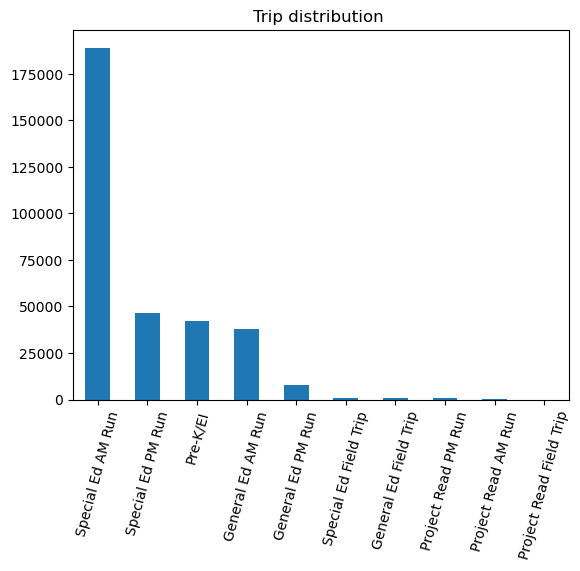

In [43]:
df_clean['Run_Type'].value_counts().plot(kind = 'bar') 
plt.title('Trip distribution ')
plt.xticks(rotation = 75) #Data heavily weighted towards Special Ed AM in terms of quantity 

In [44]:
df_clean.head(10)

,School_Year,Run_Type,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,Bus_Company_Name,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,Have_You_Alerted_OPT,Informed_On,Last_Updated_On,Breakdown_or_Running_Late,School_Age_or_PreK,Month,Delay,Bus_Number
1,2015-2016,Special Ed AM Run,M351,Heavy Traffic,06716,2015-11-05 08:10:00,2015-11-05T08:12:00.000,Manhattan,HOYT TRANSPORTATION CORP.,2,Yes,Yes,No,2015-11-05T08:12:00.000,2015-11-05T08:13:34.000,Running Late,School-Age,11,20,1260.0
2,2015-2016,Pre-K/EI,3,Heavy Traffic,C445,2015-11-05 08:09:00,2015-11-05T08:13:00.000,Bronx,"G.V.C., LTD.",8,Yes,Yes,Yes,2015-11-05T08:13:00.000,2015-11-05T08:13:22.000,Running Late,Pre-K,11,15,418.0
3,2015-2016,Special Ed AM Run,M271,Heavy Traffic,02699,2015-11-05 08:12:00,2015-11-05T08:14:00.000,Manhattan,"RELIANT TRANS, INC. (B232",6,No,No,No,2015-11-05T08:14:00.000,2015-11-05T08:14:04.000,Running Late,School-Age,11,15,4522.0
5,2015-2016,Special Ed AM Run,W796,Heavy Traffic,75407,2015-11-05 07:58:00,2015-11-05T08:14:00.000,Westchester,CHILDREN`S TRANS INC. (B2,1,Yes,Yes,Yes,2015-11-05T08:14:00.000,2015-11-05T08:14:15.000,Running Late,School-Age,11,30,1502.0
6,2015-2016,Special Ed AM Run,W633,Heavy Traffic,75670,2015-11-05 08:24:00,2015-11-05T08:15:00.000,Westchester,MAR-CAN TRANSPORT CO. INC,3,Yes,No,No,2015-11-05T08:15:00.000,2015-11-05T08:16:53.000,Running Late,School-Age,11,20,142.0
7,2015-2016,Special Ed AM Run,M678,Heavy Traffic,03417,2015-11-05 08:15:00,2015-11-05T08:16:00.000,Manhattan,LEESEL TRANSP CORP (B2192,3,Yes,Yes,No,2015-11-05T08:16:00.000,2015-11-05T08:16:22.000,Running Late,School-Age,11,15,1417.0
8,2015-2016,Special Ed AM Run,M126,Heavy Traffic,01450,2015-11-05 07:55:00,2015-11-05T08:17:00.000,Manhattan,CONSOLIDATED BUS TRANS. I,5,Yes,Yes,Yes,2015-11-05T08:17:00.000,2015-11-05T08:17:07.000,Running Late,School-Age,11,30,56102.0
9,2015-2016,Special Ed AM Run,M922,Heavy Traffic,02930,2015-11-05 08:16:00,2015-11-05T08:17:00.000,Manhattan,LEESEL TRANSP CORP (B2192,3,Yes,Yes,No,2015-11-05T08:17:00.000,2015-11-05T08:17:03.000,Running Late,School-Age,11,20,1344.0
10,2015-2016,Special Ed AM Run,M490,Heavy Traffic,03004,2015-11-05 08:19:00,2015-11-05T08:20:00.000,Manhattan,LEESEL TRANSP CORP (B2192,3,Yes,Yes,No,2015-11-05T08:20:00.000,2015-11-05T08:20:09.000,Running Late,School-Age,11,20,1358.0
11,2015-2016,Pre-K/EI,10,Heavy Traffic,C601,2015-11-05 08:19:00,2015-11-05T08:20:00.000,Bronx,"G.V.C., LTD.",13,Yes,Yes,No,2015-11-05T08:20:00.000,2015-11-05T08:20:42.000,Running Late,Pre-K,11,30,899.0


In [45]:
df_clean.nunique()

School_Year                             5
Run_Type                               10
Route_Number                        13861
Reason                                 10
Schools_Serviced                    17590
Occurred_On                        131517
Created_On                         139800
Boro                                   11
Bus_Company_Name                      118
Number_Of_Students_On_The_Bus         235
Has_Contractor_Notified_Schools         2
Has_Contractor_Notified_Parents         2
Have_You_Alerted_OPT                    2
Informed_On                        139800
Last_Updated_On                    126792
Breakdown_or_Running_Late               2
School_Age_or_PreK                      2
Month                                  12
Delay                                 199
Bus_Number                           8848
dtype: int64

### Selected Features 1

In [46]:
from sklearn.model_selection import train_test_split

y = df_clean['Delay'] #store target variable
X = df_clean[['School_Year','Run_Type','Reason','Boro','Bus_Company_Name','Number_Of_Students_On_The_Bus','Breakdown_or_Running_Late',
             'School_Age_or_PreK']] #Added bus company name/school year features
#Convert data to dummies to enable modeling / convert into binary form
dummy_df = pd.get_dummies(X) 
print(dummy_df.shape)
print(y.shape)

(325585, 159)
(325585,)


In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train, y_test = train_test_split(dummy_df,y,test_size = .2,
                                                   random_state = 40)

## Algorithm

### Gradient boosted tree

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.1],
    'loss': ['ls', 'lad']
}

# Create a GradientBoostingRegressor object
gbr = GradientBoostingRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

# Use the best estimator to make predictions on the testing set
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate the mean absolute error (MAE) and root mean squared logarithmic error (RMSLE) of the predictions
gbr_mae1 = mean_absolute_error(y_test, y_pred)

# Calculate the RMSLE, with absolute value transformation for negative values
y_test_abs = np.abs(y_test)
y_pred_abs = np.abs(y_pred)
gbr_rmsle1 = np.sqrt(mean_squared_log_error(y_test_abs, y_pred_abs))

# Calculate the cross-validated MAE and RMSLE scores
gbr_cv_mae1 = np.mean(cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
gbr_cv_rmsle1 = np.mean(cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_log_error'))

print("Gradient Boosted Tree MAE:", gbr_mae1)
print("Gradient Boosted Tree RMSLE:", gbr_rmsle1)
print("Cross-validated MAE:", -gbr_cv_mae1)
print("Cross-validated RMSLE:", np.sqrt(-gbr_cv_rmsle1))


### Multi-layer Perceptron (MLP)

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

# Define the parameter grid to search over
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive']
}

# Create a MLPRegressor object
mlp = MLPRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

# Use the best estimator to make predictions on the testing set
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate the mean absolute error (MAE) and root mean squared logarithmic error (RMSLE) of the predictions
mlp_mae1 = mean_absolute_error(y_test, y_pred)

# Calculate the RMSLE, with absolute value transformation for negative values
y_test_abs = np.abs(y_test)
y_pred_abs = np.abs(y_pred)
mlp_rmsle1 = np.sqrt(mean_squared_log_error(y_test_abs, y_pred_abs))

# Calculate the cross-validated MAE and RMSLE scores
mlp_cv_mae1 = np.mean(cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
mlp_cv_rmsle1 = np.mean(cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_log_error'))

print("Multi-layer Perceptron MAE:", mlp_mae1)
print("Multi-layer Perceptron RMSLE:", mlp_rmsle1)
print("Cross-validated MAE:", -mlp_cv_mae1)
print("Cross-validated RMSLE:", np.sqrt(-mlp_cv_rmsle1))


### Neural Network

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

# Define the neural network model
def create_nn_model():
    model = Sequential()
    model.add(Dense(100, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Create a KerasRegressor object
nn = KerasRegressor(build_fn=create_nn_model, epochs=50, batch_size=32, verbose=0)

# Use cross-validation to evaluate the model
nn_cv_mae1 = np.mean(cross_val_score(nn, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
nn_cv_rmsle1 = np.mean(cross_val_score(nn, X_train, y_train, cv=5, scoring='neg_mean_squared_log_error'))

# Fit the model to the training data
nn.fit(X_train, y_train)

# Use the model to make predictions on the testing set
y_pred = nn.predict(X_test)

# Calculate the mean absolute error (MAE) and root mean squared logarithmic error (RMSLE) of the predictions
nn_mae1 = mean_absolute_error(y_test, y_pred)

# Calculate the RMSLE, with absolute value transformation for negative values
y_test_abs = np.abs(y_test)
y_pred_abs = np.abs(y_pred)
nn_rmsle1 = np.sqrt(mean_squared_log_error(y_test_abs, y_pred_abs))

print("Neural Network MAE:", nn_mae1)
print("Neural Network RMSLE:", nn_rmsle1)
print("Cross-validated MAE:", -nn_cv_mae1)
print("Cross-validated RMSLE:", np.sqrt(-nn_cv_rmsle1))


### XGBoost

In [ ]:
from xgboost import XGBRegressor

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 0.8]
}

# Create an XGBRegressor object
xgb = XGBRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

# Use the best estimator to make predictions on the testing set
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate the mean absolute error (MAE) and root mean squared logarithmic error (RMSLE) of the predictions
xgb_mae1 = mean_absolute_error(y_test, y_pred)

# Calculate the RMSLE, with absolute value transformation for negative values
y_test_abs = np.abs(y_test)
y_pred_abs = np.abs(y_pred)
xgb_rmsle1 = np.sqrt(mean_squared_log_error(y_test_abs, y_pred_abs))

# Calculate the cross-validated MAE and RMSLE scores
xgb_cv_mae1 = np.mean(cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
xgb_cv_rmsle1 = np.mean(cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_log_error'))

print("XGBoost MAE:", xgb_mae1)
print("XGBoost RMSLE:", xgb_rmsle1)
print("Cross-validated MAE:", -xgb_cv_mae1)
print("Cross-validated RMSLE:", np.sqrt(-xgb_cv_rmsle1))


### ADA Boosting

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1],
    'loss': ['linear', 'square', 'exponential']
}

# Create an AdaBoostRegressor object
ada = AdaBoostRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=ada, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

# Use the best estimator to make predictions on the testing set
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate the mean absolute error (MAE) and root mean squared logarithmic error (RMSLE) of the predictions
ada_mae1 = mean_absolute_error(y_test, y_pred)

# Calculate the RMSLE, with absolute value transformation for negative values
y_test_abs = np.abs(y_test)
y_pred_abs = np.abs(y_pred)
ada_rmsle1 = np.sqrt(mean_squared_log_error(y_test_abs, y_pred_abs))

# Calculate the cross-validated MAE and RMSLE scores
ada_cv_mae1 = np.mean(cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
ada_cv_rmsle1 = np.mean(cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_log_error'))

print("ADA Boosting MAE:", ada_mae1)
print("ADA Boosting RMSLE:", ada_rmsle1)
print("Cross-validated MAE:", -ada_cv_mae1)
print("Cross-validated RMSLE:", np.sqrt(-ada_cv_rmsle1))


## Evaluate the reseult

In [ ]:
# Data for the bar graph
labels = ['GBR', 'MLP', 'NN', 'XGB', 'ADA']
rmsle_scores = [round(gbr_rmsle1, 2), round(mlp_rmsle1, 2), round(nn_rmsle1, 2), round(xgb_rmsle1, 2), round(ada_rmsle1, 2)]
cv_rmsle_scores = [round(np.sqrt(-gbr_cv_rmsle1), 2), round(np.sqrt(-mlp_cv_rmsle1), 2), round(np.sqrt(-nn_cv_rmsle1), 2), round(np.sqrt(-xgb_cv_rmsle1), 2), round(np.sqrt(-ada_cv_rmsle1), 2)]

# Set up the bar graph
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rmsle_scores, width, label='RMSLE')
rects2 = ax.bar(x + width/2, cv_rmsle_scores, width, label='CV_RMSLE')

# Add labels and title
ax.set_xlabel('Algorithm')
ax.set_ylabel('Score')
ax.set_title('Comparison of Regression Models (RMSLE vs CV_RMSLE)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to add labels to the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to the bars
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [ ]:
# Data for the bar graph
labels = ['GBR', 'MLP', 'NN', 'XGB', 'ADA']
mae_scores = [round(gbr_mae1, 2), round(mlp_mae1, 2), round(nn_mae1, 2), round(xgb_mae1, 2), round(ada_mae1, 2)]
cv_mae_scores = [round(-gbr_cv_mae1, 2), round(-mlp_cv_mae1, 2), round(-nn_cv_mae1, 2), round(-xgb_cv_mae1, 2), round(-ada_cv_mae1, 2)]

# Set up the bar graph
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae_scores, width, label='MAE')
rects2 = ax.bar(x + width/2, cv_mae_scores, width, label='CV_MAE')

# Add labels and title
ax.set_xlabel('Algorithm')
ax.set_ylabel('Score')
ax.set_title('Comparison of Regression Models (MAE vs CV_MAE)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to add labels to the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to the bars
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

### Selected Features 2

In [ ]:
y = df_clean['Delay'] #store target variable
X = df_clean[['School_Year','Run_Type','Reason','Boro','Bus_Company_Name','Number_Of_Students_On_The_Bus','Breakdown_or_Running_Late',
             'School_Age_or_PreK','Schools_Serviced', 'Has_Contractor_Notified_Parents','Has_Contractor_Notified_Schools']] 
    #added additional features related to contractors 
dummy_df = pd.get_dummies(X) #look familiar? 
X_train, X_test,y_train, y_test = train_test_split(dummy_df,y,test_size = .2, random_state = 40) #Split into 20% test data

## Algorithm

### Gradient boosted tree

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.1],
    'loss': ['ls', 'lad']
}

# Create a GradientBoostingRegressor object
gbr = GradientBoostingRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

# Use the best estimator to make predictions on the testing set
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate the mean absolute error (MAE) and root mean squared logarithmic error (RMSLE) of the predictions
gbr_mae2 = mean_absolute_error(y_test, y_pred)

# Calculate the RMSLE, with absolute value transformation for negative values
y_test_abs = np.abs(y_test)
y_pred_abs = np.abs(y_pred)
gbr_rmsle2 = np.sqrt(mean_squared_log_error(y_test_abs, y_pred_abs))

# Calculate the cross-validated MAE and RMSLE scores
gbr_cv_mae2 = np.mean(cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
gbr_cv_rmsle2 = np.mean(cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_log_error'))

print("Gradient Boosted Tree MAE:", gbr_mae2)
print("Gradient Boosted Tree RMSLE:", gbr_rmsle2)
print("Cross-validated MAE:", -gbr_cv_mae2)
print("Cross-validated RMSLE:", np.sqrt(-gbr_cv_rmsle2))


### Multi-layer Perceptron (MLP)

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

# Define the parameter grid to search over
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive']
}

# Create a MLPRegressor object
mlp = MLPRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

# Use the best estimator to make predictions on the testing set
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate the mean absolute error (MAE) and root mean squared logarithmic error (RMSLE) of the predictions
mlp_mae2 = mean_absolute_error(y_test, y_pred)

# Calculate the RMSLE, with absolute value transformation for negative values
y_test_abs = np.abs(y_test)
y_pred_abs = np.abs(y_pred)
mlp_rmsle2 = np.sqrt(mean_squared_log_error(y_test_abs, y_pred_abs))

# Calculate the cross-validated MAE and RMSLE scores
mlp_cv_mae2 = np.mean(cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
mlp_cv_rmsle2 = np.mean(cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_log_error'))

print("Multi-layer Perceptron MAE:", mlp_mae2)
print("Multi-layer Perceptron RMSLE:", mlp_rmsle2)
print("Cross-validated MAE:", -mlp_cv_mae2)
print("Cross-validated RMSLE:", np.sqrt(-mlp_cv_rmsle2))


### Neural Network

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

# Define the neural network model
def create_nn_model():
    model = Sequential()
    model.add(Dense(100, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Create a KerasRegressor object
nn = KerasRegressor(build_fn=create_nn_model, epochs=50, batch_size=32, verbose=0)

# Use cross-validation to evaluate the model
nn_cv_mae2 = np.mean(cross_val_score(nn, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
nn_cv_rmsle2 = np.mean(cross_val_score(nn, X_train, y_train, cv=5, scoring='neg_mean_squared_log_error'))

# Fit the model to the training data
nn.fit(X_train, y_train)

# Use the model to make predictions on the testing set
y_pred = nn.predict(X_test)

# Calculate the mean absolute error (MAE) and root mean squared logarithmic error (RMSLE) of the predictions
nn_mae2 = mean_absolute_error(y_test, y_pred)

# Calculate the RMSLE, with absolute value transformation for negative values
y_test_abs = np.abs(y_test)
y_pred_abs = np.abs(y_pred)
nn_rmsle2 = np.sqrt(mean_squared_log_error(y_test_abs, y_pred_abs))

print("Neural Network MAE:", nn_mae2)
print("Neural Network RMSLE:", nn_rmsle2)
print("Cross-validated MAE:", -nn_cv_mae2)
print("Cross-validated RMSLE:", np.sqrt(-nn_cv_rmsle2))


### XGBoost

In [ ]:
from xgboost import XGBRegressor

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 0.8]
}

# Create an XGBRegressor object
xgb = XGBRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

# Use the best estimator to make predictions on the testing set
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate the mean absolute error (MAE) and root mean squared logarithmic error (RMSLE) of the predictions
xgb_mae2 = mean_absolute_error(y_test, y_pred)

# Calculate the RMSLE, with absolute value transformation for negative values
y_test_abs = np.abs(y_test)
y_pred_abs = np.abs(y_pred)
xgb_rmsle2 = np.sqrt(mean_squared_log_error(y_test_abs, y_pred_abs))

# Calculate the cross-validated MAE and RMSLE scores
xgb_cv_mae2 = np.mean(cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
xgb_cv_rmsle2 = np.mean(cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_log_error'))

print("XGBoost MAE:", xgb_mae2)
print("XGBoost RMSLE:", xgb_rmsle2)
print("Cross-validated MAE:", -xgb_cv_mae2)
print("Cross-validated RMSLE:", np.sqrt(-xgb_cv_rmsle2))


### ADA Boosting

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'loss': ['linear', 'exponential']
}

# Create an AdaBoostRegressor object
ada = AdaBoostRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=ada, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

# Use the best estimator to make predictions on the testing set
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate the mean absolute error (MAE) and root mean squared logarithmic error (RMSLE) of the predictions
ada_mae2 = mean_absolute_error(y_test, y_pred)

# Calculate the RMSLE, with absolute value transformation for negative values
y_test_abs = np.abs(y_test)
y_pred_abs = np.abs(y_pred)
ada_rmsle2 = np.sqrt(mean_squared_log_error(y_test_abs, y_pred_abs))

# Calculate the cross-validated MAE and RMSLE scores
ada_cv_mae2 = np.mean(cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
ada_cv_rmsle2 = np.mean(cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_log_error'))

print("ADA Boosting MAE:", ada_mae2)
print("ADA Boosting RMSLE:", ada_rmsle2)
print("Cross-validated MAE:", -ada_cv_mae2)
print("Cross-validated RMSLE:", np.sqrt(-ada_cv_rmsle2))

## Evaluate the reseult

In [ ]:
# Data for the bar graph
labels = ['GBR', 'MLP', 'NN', 'XGB', 'ADA']
rmsle_scores = [round(gbr_rmsle2, 2), round(mlp_rmsle2, 2), round(nn_rmsle1, 2), round(xgb_rmsle2, 2), round(ada_rmsle2, 2)]
cv_rmsle_scores = [round(np.sqrt(-gbr_cv_rmsle2), 2), round(np.sqrt(-mlp_cv_rmsle2), 2), round(np.sqrt(-nn_cv_rmsle2), 2), round(np.sqrt(-xgb_cv_rmsle2), 2), round(np.sqrt(-ada_cv_rmsle2), 2)]

# Set up the bar graph
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rmsle_scores, width, label='RMSLE')
rects2 = ax.bar(x + width/2, cv_rmsle_scores, width, label='CV_RMSLE')

# Add labels and title
ax.set_xlabel('Algorithm')
ax.set_ylabel('Score')
ax.set_title('Comparison of Regression Models (RMSLE vs CV_RMSLE)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to add labels to the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to the bars
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [ ]:
# Data for the bar graph
labels = ['GBR', 'MLP', 'NN', 'XGB', 'ADA']
mae_scores = [round(gbr_mae2, 2), round(mlp_mae2, 2), round(nn_mae2, 2), round(xgb_mae2, 2), round(ada_mae2, 2)]
cv_mae_scores = [round(-gbr_cv_mae2, 2), round(-mlp_cv_mae2, 2), round(-nn_cv_mae2, 2), round(-xgb_cv_mae2, 2), round(-ada_cv_mae2, 2)]

# Set up the bar graph
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae_scores, width, label='MAE')
rects2 = ax.bar(x + width/2, cv_mae_scores, width, label='CV_MAE')

# Add labels and title
ax.set_xlabel('Algorithm')
ax.set_ylabel('Score')
ax.set_title('Comparison of Regression Models (MAE vs CV_MAE)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to add labels to the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to the bars
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# Deployment

In [ ]:
from sklearn.model_selection import train_test_split
# feature 1 X and y
y = df_clean['Delay'] #store target variable
X = df_clean[['School_Year','Run_Type','Reason','Boro','Bus_Company_Name','Number_Of_Students_On_The_Bus','Breakdown_or_Running_Late',
             'School_Age_or_PreK']] 

dummy_df = pd.get_dummies(X)

X_train, X_test,y_train, y_test = train_test_split(dummy_df,y,test_size = .2, random_state = 40)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV

# Instantiate a new GradientBoostingRegressor object with the best hyperparameters
gbr_best = GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, loss='lad')

# Fit the model on the training data
gbr_best.fit(X_train, y_train)

joblib.dump(gbr_best, 'trained_model.pkl')

In [ ]:
from sklearn.preprocessing import StandardScaler

#row num
row_num = 34

# Best trained model
model = joblib.load('trained_model.pkl')

# input
sample_df = dummy_df.iloc[row_num] 
print('actual result:', y[row_num])

# reshape
sample_df = sample_df.values.reshape(1, -1)

# Perform prediction using the loaded model
prediction = model.predict(sample_df)

# Print the prediction result
print('Predicted result:', prediction)

In [ ]:
print(df_clean.min())

In [ ]:
print(df_clean.max())

In [ ]:
for i in range(10, 22):
    print(df_clean.iloc[i])

In [ ]:
import tkinter as tk
from tkinter import messagebox
import pandas as pd
import joblib

# Load the trained model
model = joblib.load('trained_model.pkl')

# Define the function to perform the prediction
def predict_delay():
    # Retrieve input data from the GUI
    school_year = school_year_entry.get()
    run_type = run_type_entry.get()
    reason = reason_entry.get()
    boro = boro_entry.get()
    bus_company_name = bus_company_name_entry.get()
    num_students = num_students_entry.get()
    breakdown_or_late = breakdown_or_late_entry.get()
    school_age_or_prek = school_age_or_prek_entry.get()
    
    # Create a DataFrame for the input data
    input_data = {
        'School_Year': [school_year],
        'Run_Type': [run_type],
        'Reason': [reason],
        'Boro': [boro],
        'Bus_Company_Name': [bus_company_name],
        'Number_Of_Students_On_The_Bus': [num_students],
        'Breakdown_or_Running_Late': [breakdown_or_late],
        'School_Age_or_PreK': [school_age_or_prek]
    }
    
    # Create a new dataframe with only the columns for prediction
    X = df_clean[['School_Year','Run_Type','Reason','Boro','Bus_Company_Name','Number_Of_Students_On_The_Bus','Breakdown_or_Running_Late','School_Age_or_PreK']]

    # Append the input data to the dataframe
    X = X.append(pd.DataFrame(input_data), ignore_index=True)

    # Get the list of categorical variables
    cat_cols = ['School_Year', 'Run_Type', 'Reason', 'Boro', 'Bus_Company_Name', 'Breakdown_or_Running_Late', 'School_Age_or_PreK']

    #Convert data to dummies to enable modeling
    dummy_df = pd.get_dummies(X, columns=cat_cols) 

    # Perform prediction using the loaded model
    prediction = model.predict(dummy_df.iloc[[-1]])

    # Display the prediction result in the GUI
    messagebox.showinfo("Prediction Result", f"The predicted delay is {round(prediction[0], 2)} minutes.")


# Create the main window for the GUI
root = tk.Tk()
root.title("Bus Delay Prediction")

# Create labels and entry fields for input data
school_year_label = tk.Label(root, text="School Year")
school_year_label.grid(row=0, column=0)
school_year_entry = tk.Entry(root)
school_year_entry.insert(0, '2015-2016')
school_year_entry.grid(row=0, column=1)

run_type_label = tk.Label(root, text="Run Type")
run_type_label.grid(row=1, column=0)
run_type_entry = tk.Entry(root)
run_type_entry.insert(0,df_clean.iloc[20]['Run_Type'])
run_type_entry.grid(row=1, column=1)

reason_label = tk.Label(root, text="Reason")
reason_label.grid(row=2, column=0)
reason_entry = tk.Entry(root)
reason_entry.insert(0, df_clean.iloc[30]['Reason'])
reason_entry.grid(row=2, column=1)

boro_label = tk.Label(root, text="Boro")
boro_label.grid(row=3, column=0)
boro_entry = tk.Entry(root)
boro_entry.insert(0, df_clean.iloc[100]['Boro'])
boro_entry.grid(row=3, column=1)

bus_company_name_label = tk.Label(root, text="Bus Company Name")
bus_company_name_label.grid(row=4, column=0)
bus_company_name_entry = tk.Entry(root)
bus_company_name_entry.insert(0, df_clean.iloc[50]['Bus_Company_Name'])
bus_company_name_entry.grid(row=4, column=1)

num_students_label = tk.Label(root, text="Number of Students on Bus")
num_students_label.grid(row=5, column=0)
num_students_entry = tk.Entry(root)
num_students_entry.insert(0, df_clean.iloc[90]['Number_Of_Students_On_The_Bus'])
num_students_entry.grid(row=5, column=1)

breakdown_or_late_label = tk.Label(root, text="Breakdown or Running Late?")
breakdown_or_late_label.grid(row=6, column=0)
breakdown_or_late_entry = tk.Entry(root)
breakdown_or_late_entry.insert(0, df_clean.iloc[300]['Breakdown_or_Running_Late'])
breakdown_or_late_entry.grid(row=6, column=1)

school_age_or_prek_label = tk.Label(root, text="School Age or Pre-K?")
school_age_or_prek_label.grid(row=7, column=0)
school_age_or_prek_entry = tk.Entry(root)
school_age_or_prek_entry.insert(0, df_clean.iloc[600]['School_Age_or_PreK'])
school_age_or_prek_entry.grid(row=7, column=1)

#Create a button to submit the input data and perform prediction
predict_button = tk.Button(root, text="Predict Delay", command=predict_delay)
predict_button.grid(row=8, column=0, columnspan=2)

#Start the GUI
root.mainloop()